<a href="https://colab.research.google.com/github/munich-ml/MLPy2021/blob/main/31_fMNIST_classifier_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

## References
Resources used to create this notebook:
- [scikit-learn website](https://scikit-learn.org)
- [Matplotlib website](https://matplotlib.org/)
- [Wikipedia](https://en.wikipedia.org/wiki/Main_Page)
- Hands-on Machine Learning with Scikit-learn, Keras & TensorFlow, Aurelien Geron, [Book on Amazon](https://www.amazon.de/Aur%C3%A9lien-G%C3%A9ron/dp/1492032646/ref=sr_1_3?__mk_de_DE=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=Hands-on+Machine+Learning+with+Scikit-learn%2C+Keras+%26+TensorFlow%2C+Aurelien+Geron%2C&qid=1589875241&sr=8-3)
- Introduction to Machine Learning with Python, Andreas Mueller, [Book on Amazon](https://www.amazon.de/Introduction-Machine-Learning-Python-Scientists/dp/1449369413)


## Setup

First, do the common imports.

Tensorflow must be 2.x, because there are major changes from 1.x

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import os
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Setup matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

in_colab = 'google.colab' in sys.modules   # check if note is executed within Colab

# Forces tensorflow version (only in colab)
if in_colab:
    %tensorflow_version 2.x           

# Clone the repository if executed in Google Colab
if in_colab:  
    if "MLPy2021" in os.listdir():
        !git -C MLPy2021 pull
    else:
        !git clone https://github.com/munich-ml/MLPy2021/

# lib.helper_funcs.py. The import path depends on Colab or local execution 
if in_colab:
    from MLPy2021.lib.helper_funcs import pickle_out
else: 
    from lib.helper_funcs import pickle_out


Cloning into 'MLPy2021'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (313/313), done.
remote: Compressing objects: 100% (274/274), done.
remote: Total 313 (delta 164), reused 107 (delta 32), pack-reused 0
Receiving objects: 100% (313/313), 12.30 MiB | 11.41 MiB/s, done.
Resolving deltas: 100% (164/164), done.


# Get the data

**MNIST** is probably **THE classical dataset for image recognition**. 

A more challanging dataset is the **[fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)** from Zalando.

Keras has a number of functions to load popular datasets in `keras.datasets`. 

The fashion MNIST dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:


In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

From the dataset documentation we know, that the **labels** are **class IDs** that correspond to the following **`class_names`**:

In [4]:
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [7]:
y_train_full[0]

9

In [6]:
class_names[y_train_full[0]]

'Ankle boot'

Plot part of the dataset to get an overview


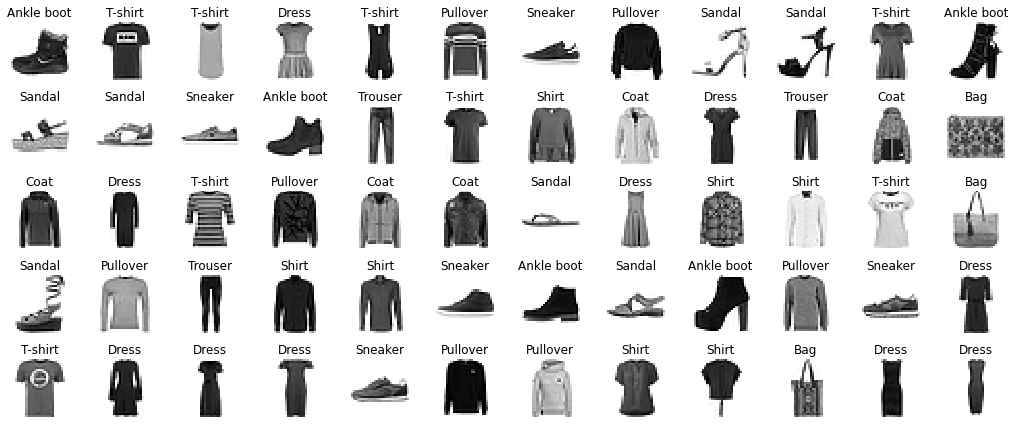

In [13]:
# code for viewing, not for teaching
n_rows = 5
n_cols = 12
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_full[index], cmap=plt.cm.binary, interpolation="nearest")
        plt.title(class_names[y_train_full[index]], fontsize=12)
        plt.axis('off')
plt.tight_layout()
plt.show()

##Inpect the data


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [11]:
X_train_full.shape

(60000, 28, 28)

In [19]:
sample_img = X_train_full[100,:,:]
sample_img.shape

(28, 28)

One may plot an image using Matplotlib's `imshow()` function::

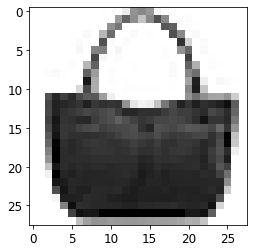

In [23]:
plt.imshow(sample_img, cmap=plt.cm.binary);

Each pixel intensity is an 8bit interger value.
- 0 is white
- 255 is black

In [30]:
sample_img.dtype

dtype('uint8')

In [28]:
pd.Series(sample_img.flatten()).value_counts().sort_index()

0      300
1       17
2       12
3        2
4        6
      ... 
240      1
241      1
249      1
250      1
255     15
Length: 147, dtype: int64

In [31]:
sample_img[:,:13]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,  18],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  99, 155],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   0, 110, 136,   0],
       [  0,   0,   0,   0,   0,   1,   0,   6,   0,  72, 147,   0,   0],
       [  0,   0,   0,   0,   0,   1,   5,   0,   0, 174,   4,   0,   4],
       [  0,   0,   0,   0,   0,   0,   8,   0, 125, 128,   0,   9,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 184,   9,   0,   4,   0],
       [  0,   0,   0,   1,   0,   2,   0,  73, 158,   0,   0,   0,   0],
       [  0,   0,   2,   5,   1,   0,   0, 157,  98,   0,   2,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 231,  84,   0,   2,   1,   1],
       [  0,   0,   0,   0,   0,   0,  38, 183,  81,   0,   0,   0,   2],
       [  0,   0, 173, 216, 193, 213, 183, 164, 167,  98,  16,   0,   0],
       [  0,   0, 185, 221, 217, 210, 202, 222, 200, 206, 202, 204, 109],
       [  0,   0, 183, 220, 205, 200, 

## Scale the data

Since we are going to train the neural network using **Gradient Descent**, we must scale the input features. 

For simplicity, we just divide by 255.0 (which converts the features from `int` to `float`)

In [32]:
scale = X_train_full.max()
scale

255

In [35]:
X_train_full = X_train_full / scale
X_test = X_test / scale

In [36]:
X_test.max()

1.0

##Split a validation set

Let's split the *full training set* into a *validation set* and a (smaller) *training set*. But first check whether the images are sorted.

The labels are the class IDs (represented as uint8), from 0 to 9:

In [37]:
y_train_full

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Assessing the *class ID's* randomness: 

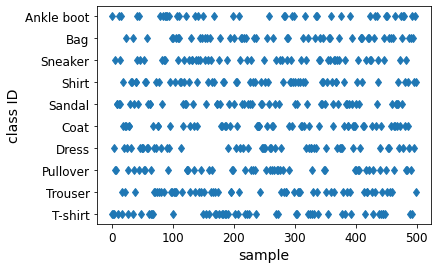

In [41]:
plt.plot(y_train_full[:500], "d")
plt.xlabel("sample"), plt.ylabel("class ID")
plt.yticks(range(len(class_names)), labels=class_names);

The distribution seems random. Therefore the training set can be splitted.

In [42]:
valid_size = 5000
X_valid, X_train = X_train_full[:valid_size], X_train_full[valid_size:]
y_valid, y_train = y_train_full[:valid_size], y_train_full[valid_size:]

Plot the shapes of the resulting sets

In [55]:
for item in ("X_train_full", "X_train", "X_valid", "X_test"):
    print("{:20}{}".format(item+".shape", eval(item + ".shape")))

X_train_full.shape  (60000, 28, 28)
X_train.shape       (55000, 28, 28)
X_valid.shape       (5000, 28, 28)
X_test.shape        (10000, 28, 28)


# Build a model

The folloging  code creates a **classification MLP** (multi layer perceptron) with 2 hidden layers:

In [56]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

Alternatively to using `model.add` we can pass a list of layers to the `Sequential()` constructor

In [57]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(47)

In [58]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation=keras.activations.relu),
    keras.layers.Dense(100, activation=keras.activations.relu),
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [59]:
keras.activations.relu([-2, -1, 0, 1, 2])

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 1, 2], dtype=int32)>

## Model summary

Let's print a summary of the model, using `model.summary()`


In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Note the huge amount of (trainable) parameters. For example, the first hidden layer has 784 * 300 connection weights, plus 300 bias terms. This gives the model quite a flexibility to fit the training data, but it's also prone to overfitting, especially with few traning data.

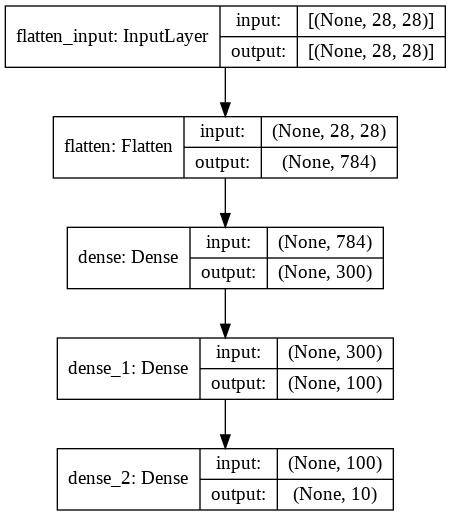

In [65]:
keras.utils.plot_model(model, show_shapes=True)

The layers of the model can be accessed with `model.layers`

In [66]:
for i, layer in enumerate(model.layers):
    print("layer {}: {}".format(i, layer.name))

layer 0: flatten
layer 1: dense
layer 2: dense_1
layer 3: dense_2


In [68]:
weights, biases = model.layers[2].get_weights()

In [69]:
weights.shape

(300, 100)

In [70]:
weights

array([[-0.08059598, -0.04436566,  0.09836388, ..., -0.00970834,
        -0.08208367, -0.08370163],
       [ 0.09863398,  0.0779072 ,  0.04579651, ...,  0.04844771,
        -0.08347219, -0.12094279],
       [ 0.03421906,  0.00415913,  0.03538304, ..., -0.02142348,
        -0.0053408 , -0.0237003 ],
       ...,
       [-0.05799503, -0.07039653,  0.04351173, ...,  0.12147508,
        -0.02084582,  0.0079603 ],
       [-0.09212115, -0.03788842, -0.00952023, ..., -0.02874079,
         0.03038765, -0.0189582 ],
       [-0.09342733,  0.03829556,  0.07831021, ..., -0.08451727,
         0.01317381, -0.06233999]], dtype=float32)

In [71]:
biases.shape

(100,)

In [72]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Note that the biases are initialized with zeros while the weights are initalized randomly. This is required to support convergence.

# Train the model

In [74]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [73]:
model.compile?

This is equivalent to:

```
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

Some explanation to the `compile` params:
- The loss must be **sparse_**categorical_crossentropy because the labels are sparse, meaning just one value per training instance and not a tensor of len(10)
- The optimizer is a simple **Stochastic Gradient Descent**
- Since this is a **classifier**, it's useful to measure **accuracy** during training 

Now, let's kick-off training using `model.fit`

In [75]:
history = model.fit(X_train, y_train, epochs=30, verbose=1,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 8s 3ms/step - loss: 0.9898 - accuracy: 0.6846 - val_loss: 0.5698 - val_accuracy: 0.8048
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5108 - accuracy: 0.8250 - val_loss: 0.4368 - val_accuracy: 0.8466
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4494 - accuracy: 0.8425 - val_loss: 0.4342 - val_accuracy: 0.8426
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4241 - accuracy: 0.8504 - val_loss: 0.3968 - val_accuracy: 0.8656
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4019 - accuracy: 0.8598 - val_loss: 0.3990 - val_accuracy: 0.8642
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3847 - accuracy: 0.8671 - val_loss: 0.3805 - val_accuracy: 0.8694
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3750 - accuracy: 0.8671 - val_loss: 0.3861 - val_accuracy:

In [ ]:
history.params

{'epochs': 30, 'steps': 1719, 'verbose': 1}

In [89]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

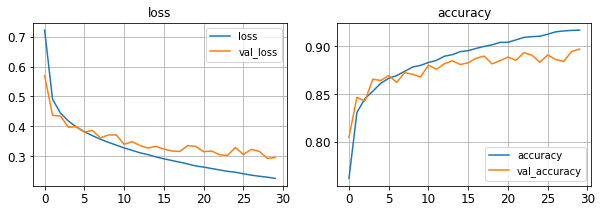

In [88]:
plt.figure(figsize=[10, 3]) 
for i, word in enumerate(["loss", "accuracy"]):
    plt.subplot(1, 2, i+1)
    for key, vals in history.history.items():
        if word in key:
            plt.plot(vals, label=key)
    plt.grid(), plt.legend(), plt.title(word)

## Mount google drive

In [90]:
mount_dir = os.path.join(os.getcwd(), "drive")
mount_dir

'/content/drive'

In [91]:
from google.colab import drive
drive.mount(mount_dir)

Mounted at /content/drive


## model.save()


In [92]:
save_dir = os.path.join(mount_dir, "My Drive", "Colab Notebooks", "models")
save_dir

'/content/drive/My Drive/Colab Notebooks/models'

In [93]:
os.path.isdir(save_dir)

True

In [94]:
fn = "fMNIST_NN_v1_ageron"
model.save(os.path.join(save_dir, fn + ".h5"))

### Save validation and test data along with the model

In [95]:
pickle_out(os.path.join(save_dir, fn+"_data.pkl"), locals(),
           X_valid, y_valid, X_test, y_test, class_names)